In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import heapq

In [2]:
# important window definition
prediction_length = 48
context_length = 72
day = 24
week = 148
month = 720
year = 8760

In [3]:
# get the Time Series data and corresponding wiki project name
def get_ts(data_location,label_location,freq):
    df_ts = pd.read_json(data_location, lines=True)
    num_pt = min(len(df_ts.iloc[1, 1]), 100000)
    print('use first ', num_pt, ' points in a time series')
    num_ts = len(df_ts)

    time_series_wiki = []
    for k in range(num_ts):
        t0 = df_ts.iloc[k, 0]
        data = df_ts.iloc[k, 1][:num_pt]
        index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
        time_series_wiki.append(pd.Series(data=data, index=index))
        
    with open(label_location) as f:
        wp_list = f.read().splitlines()  
        
    return time_series_wiki, wp_list

In [4]:
label_location = 'wp_full-20180101-20190101_get.txt'    
data_location = 'test_1year.json'
freq = 'H'

time_series_wiki, wp_list = get_ts(data_location,label_location,freq)

use first  8784  points in a time series


In [5]:
# discrete Fourier transform with FFT
def discrete_ft(x,window):
    # important variables are written explicitly
    y = x.values # signal

    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range

    # we only keep the positive frequency up to the Nyquist = 2*Fs
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(x)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('network traffic')
    ax[1].plot(cycle,abs(Y),'r') # plotting the spectrum
    ax[1].set_xlabel('cycles per '+str(window)+' hours')
    ax[1].set_ylabel('network frequency spectrum')

In [65]:
# time series characterization with FFT
def characterize_ts(ts,window):
    y = ts.values # signal
    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    # we only keep the positive frequency up to the Nyquist = 1/(2*dT), dT = sampling interval
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half
    yabs = np.abs(Y)
    
    # locate the largest 15 peaks, use them to characterise the time series
    indx = heapq.nlargest(15, range(len(yabs)), yabs.__getitem__)
    amp = heapq.nlargest(15,yabs)

    mean = yabs.mean()
    std = yabs.std()
    cyc_hday = 2.0
    cyc_day = cyc_hday / 2.0
    cyc_week = cyc_day / 7.0
    cyc_month = cyc_day / 30.0

    comp = lambda a,b : np.abs(a/b - 1) < 0.05
    ts_type = ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
    report_list = [0] * 8
    for counter, value in enumerate(indx):
        # define a peak in frequency domain
        if amp[counter] > (mean + 3*std):
            amp_norm = (amp[counter] - mean)/std
            if cycle[value] < 0.01:
                # trend (increasing, decreasing, gaussian pulse)
                report_list[0] = max(amp_norm,report_list[0])
            elif comp(cycle[value], cyc_hday):
                report_list[1] = max(amp_norm,report_list[1])
            elif comp(cycle[value], cyc_day):
                report_list[2] = max(amp_norm,report_list[2])
            elif comp(cycle[value], cyc_week):
                report_list[3] = max(amp_norm,report_list[3])
            elif comp(cycle[value], cyc_month):
                report_list[4] = max(amp_norm,report_list[4])

    if sum(report_list[:4]) > 0:
        index = report_list[:4].index(max(report_list[:4])) 
        report_list[5] = ts_type[index]
    else: 
        report_list[5] = ts_type[-1]
        
    # add a subcategory: a special day seasonality that has a periodic impulse shape    
    if (report_list[5] == 'hDay' or report_list[5] == 'Day'):
        harmonic = set(range(12))
        all_peak = set()
        for counter, value in enumerate(indx):
            if amp[counter] > (mean + 3*std):
                all_peak.add(int(round(cycle[value])))
        if len(harmonic.intersection(all_peak)) > 10 :
            report_list[5] = ts_type[-2]

    report_list[-2] = y.mean()
    report_list[-1] = y.std()
    return report_list

In [66]:
character_list = []
for item in time_series_wiki:
    character_list.append(characterize_ts(item,day))

with open(data_location[:-5] + '_stats.txt', 'w') as f:
    for item in character_list:
        for info in item:
            f.write("%s\t" % info)
        f.write("\n")    

In [67]:
df = pd.DataFrame(character_list,wp_list, 
                  columns = ['trend_score', 'hday_score', 'day_score','week_score', 'month_score','character','mean','std'])

In [68]:
df.reset_index(level=0, inplace=True)
df.rename(columns={'index':'project'}, inplace = True)

In [69]:
# now we have a workable dataframe

df.head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
0,aa.wikipedia.org,11.418841,0.000000,0.000000,0.0,7.875303,trend,27.925888,95.229821
1,aa.wikibooks.org,13.385391,0.000000,0.000000,0.0,12.325506,trend,20.088342,122.588757
2,aa.wiktionary.org,9.347850,11.925226,11.978428,0.0,0.000000,DayImpulse,5.751138,15.827372
3,ab.wikipedia.org,14.519234,0.000000,10.684804,0.0,0.000000,trend,202.561931,303.248786
4,ab.wiktionary.org,8.253239,15.463952,14.215497,0.0,4.614637,DayImpulse,6.962887,20.878857


### Given the data set, we can examine what's in there:
1. a break-down of different types of time series -- by *type*, I mean the strongest characteristic of given time series
2. detailed look of the score distributions for each type of time series

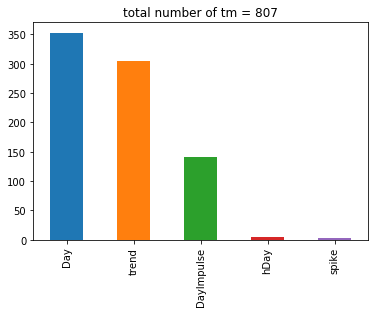

In [70]:
df['character'].value_counts().plot(kind='bar', title = 'total number of tm = {}'.format(len(df)))

12.632097872475471


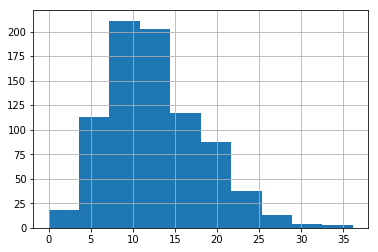

In [12]:
print(df['trend_score'].mean())
df['trend_score'].hist()

9.561388292224471


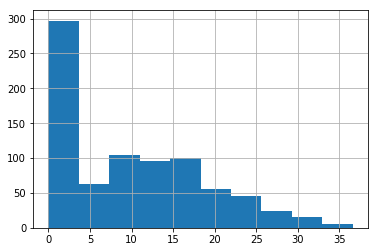

In [13]:
print(df['hday_score'].mean())
df['hday_score'].hist()

20.87345900410888


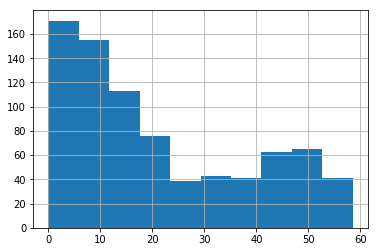

In [14]:
print(df['day_score'].mean())
df['day_score'].hist()

3.2110487819094384


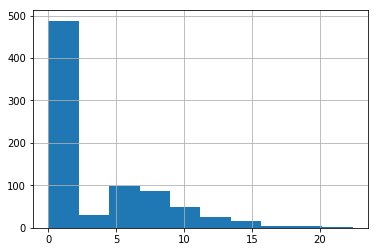

In [15]:
print(df['week_score'].mean())
df['week_score'].hist()

1.4328699110415941


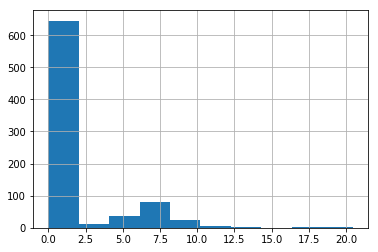

In [16]:
print(df['month_score'].mean())
df['month_score'].hist()

mean of mean over all time series..  26702.176045271026  max val  10508012.864184882  min val  0.23258196721311475


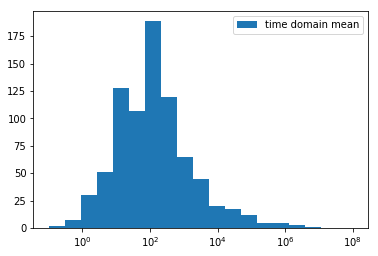

In [17]:
print('mean of mean over all time series.. ', df['mean'].mean(), ' max val ', df['mean'].max(), ' min val ', df['mean'].min())
#plt.hist(np.log(df['mean']), bins = 10, label = 'log of the mean')
plt.hist(df['mean'], bins=np.logspace(np.log10(0.1),np.log10(100000000), 20), label = 'time domain mean')
plt.gca().set_xscale("log")
plt.legend()

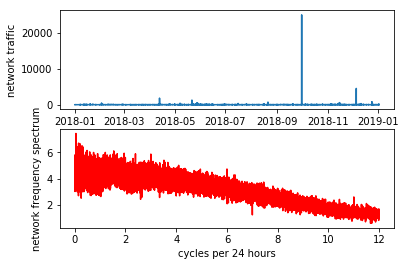

In [18]:
# a spike example: doesn't show any trend or seansonality, no distinctive peaks in freq domain
discrete_ft(time_series_wiki[16],day)

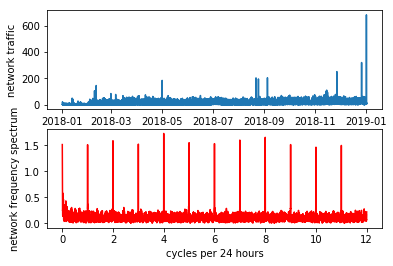

In [29]:
# Periodic harmonic, in time domain we see regular pulse with period = 1 day, in frequency domain 
discrete_ft(time_series_wiki[238],day)

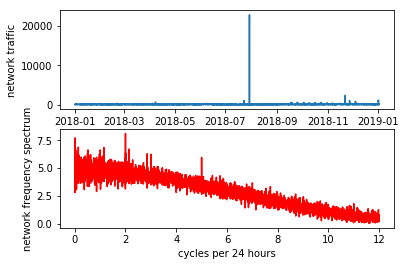

In [30]:
discrete_ft(time_series_wiki[133],day)

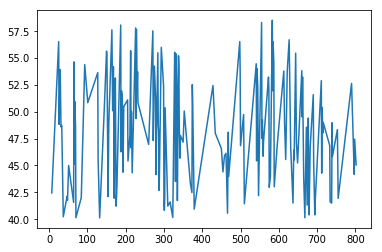

In [20]:
df.loc[((df['day_score'] > 40) & (df['character'] == 'Day')),'day_score'].plot()

the number of Day-seasonality time series with day_score > 30 is  248


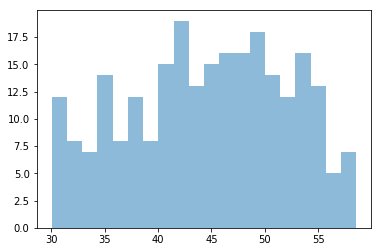

In [21]:
plt.hist(df.loc[((df['day_score'] > 30) & (df['character'] == 'Day')),'day_score'], bins = 20, alpha = 0.5)
print('the number of Day-seasonality time series with day_score > 30 is ',
      ((df['day_score'] > 30) & (df['character'] == 'Day')).sum())

the number of Trendy time series with trend_score > 10 is  237


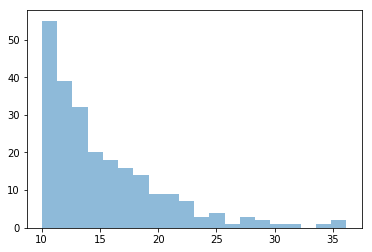

In [22]:
plt.hist(df.loc[((df['trend_score'] > 10) & (df['character'] == 'trend')),'trend_score'], bins = 20, alpha = 0.5)
print('the number of Trendy time series with trend_score > 10 is ',
      ((df['trend_score'] > 10) & (df['character'] == 'trend')).sum())

the number of Half-day seasonality time series with hday_score > 10 is  46


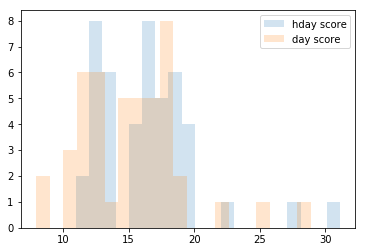

In [23]:
bins = 20
print('the number of Half-day seasonality time series with hday_score > 10 is ',
      ((df['hday_score'] > 10) & (df['character'] == 'halfDay')).sum())
plt.hist(df.loc[((df['hday_score'] > 10) & (df['character'] == 'halfDay')),'hday_score'], bins, alpha=0.2, label='hday score')
plt.hist(df.loc[((df['hday_score'] > 10) & (df['character'] == 'halfDay')),'day_score'], bins, alpha=0.2, label='day score')
plt.legend(loc='upper right')
plt.show()